# Pytorch's Cartoon GAN

**Generative Adversarial Network for Generating `Cartoon` Faces**

## Reference
- [Dataset Link](https://www.kaggle.com/datasets/imreallyjohn/cartoonset10k)
- [Notebook Referred](https://jovian.com/aakashns/06b-anime-dcgan)

## ToDo
- [x] Notebook Preparation
- [x] Data Exploration
- [x] Data Preparation
- [x] Model Definition
- [x] Model Traning
- [ ] HyperTuning (if needed)
- [x] Evaluation

### Notebook Preparation

In [1]:
# Import Libraries

import os
import cv2
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
from torchvision.datasets import ImageFolder

from PIL import Image as img
from tqdm.notebook import tqdm
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Datafile Checking

DATA_DIR = '/kaggle/input/cartoonset10k/cartoonset10k'

imagesDir = os.listdir(DATA_DIR)

print('Sample: ', imagesDir[:5])
print('Length: ', len(imagesDir))

Sample:  ['cs11221941617409717231.png', 'cs1140172971336216492.png', 'cs10497634233692504766.png', 'cs10947981428783986823.png', 'cs10249589535790648751.png']
Length:  10000


### Data Exploration

In [3]:
# Plotting Image

sampleImg = imagesDir[1]

image = mpimg.imread(f"{DATA_DIR}/{sampleImg}")
plt.imshow(image)
plt.show()

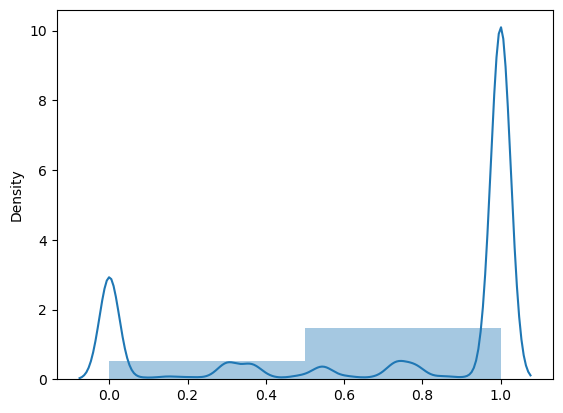

In [4]:
# Plotting Values Distribution

newImg = image.reshape(image.shape[2], (image.shape[0]*image.shape[1]))
sns.distplot(newImg, bins = 2)
plt.show()

### Data Preparation

In [5]:
# Loading Image

imageSize = 64
batchSize = 128

trainDataset = ImageFolder(
    root = '/kaggle/input/cartoonset10k/',
    transform = T.Compose([
        T.Resize(imageSize),
        T.ToTensor()
    ])
)

trainDataLoader = DataLoader(dataset = trainDataset, batch_size = batchSize, shuffle = True, num_workers = 3, pin_memory = True)

In [6]:
# Visualizing Image

def showImages(images, nmax = 64):
    fig, ax = plt.subplots(figsize = (8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow = 8).permute(1, 2, 0))

def showBatch(dl, nmax = 64):
    for images, _ in dl:
        showImages(images, nmax)
        break

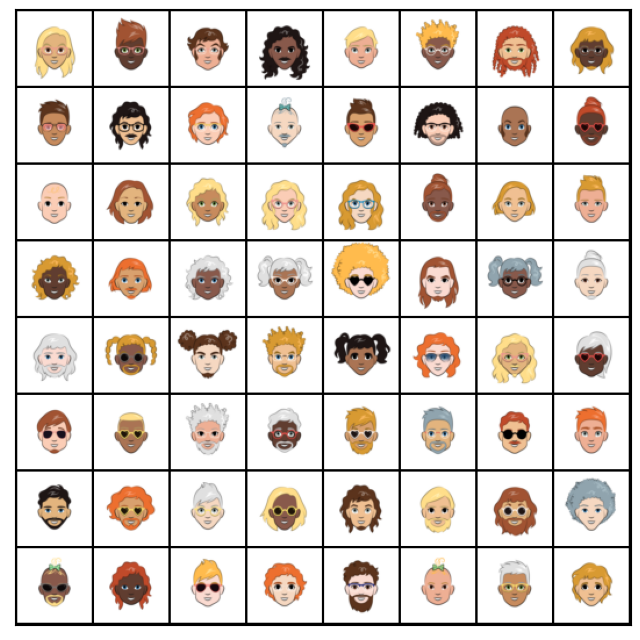

In [7]:
showBatch(trainDataLoader)

In [8]:
# Function to get Default Device

def getDefaultDevice():
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

# Function to change from cpu to gpu

def toDevice(data, device):
    if isinstance(data, (list, tuple)):
        return [toDevice(x, device) for x in data]
    return data.to(device, non_blocking = True)

# Function to change the DataLoader

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield toDevice(b, self.device)

    def __len__(self):
        return len(self.dl)

device = getDefaultDevice()
device

device(type='cuda')

In [13]:
# Loader for Training

trainDataLoader = DeviceDataLoader(trainDataLoader, device)

### Model Definition

In [15]:
# Discriminator Network

discriminator = nn.Sequential(

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid()
)

discriminator = toDevice(discriminator, device)

In [24]:
# Generator Network

latentSize = 128

generator = nn.Sequential(

    nn.ConvTranspose2d(latentSize, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

torch.Size([128, 3, 64, 64])


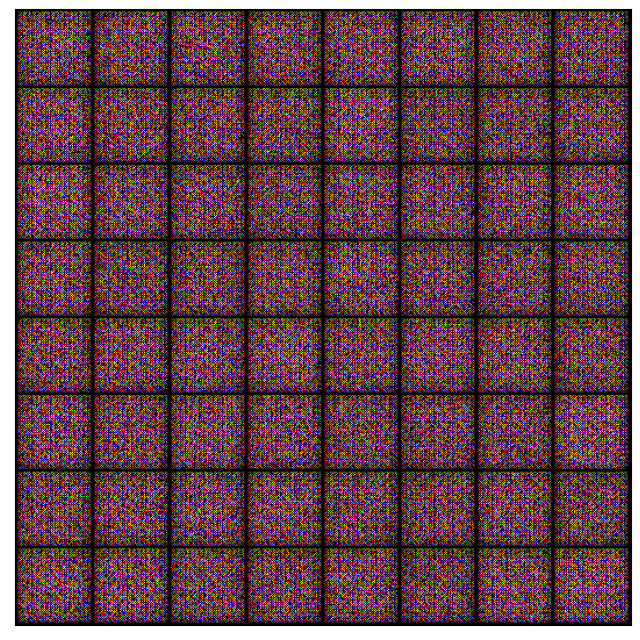

In [25]:
sampleImage = torch.randn(batchSize, latentSize, 1, 1)
fakeImages = generator(sampleImage)
print(fakeImages.shape)
showImages(fakeImages)

In [26]:
generator = toDevice(generator, device)

In [97]:
def trainDiscriminator(realImages, opt_d):
    opt_d.zero_grad()
    
    # Real Images Passing through Discriminator
    realPreds = discriminator(realImages)
    realTargets = torch.ones(realImages.size(0), 1, device = device)
    realLoss = F.binary_cross_entropy(realPreds, realTargets)
    realScore = torch.mean(realPreds).item()
    
    # Generate Fake Images
    latent = torch.randn(batchSize, latentSize, 1, 1, device = device)
    fake_images = generator(latent)

    # Fake Images Passing through Discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = realLoss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), realScore, fake_score

In [98]:
def trainGenerator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batchSize, latentSize, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batchSize, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [99]:
# Function to Save Generated Sample

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(fake_images, os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Saving generated-images-0000.png


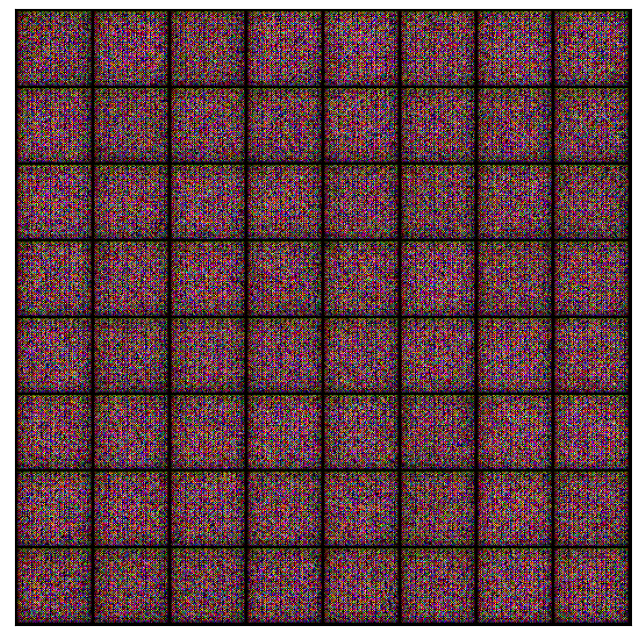

In [100]:
fixed_latent = torch.randn(64, latentSize, 1, 1, device=device)
save_samples(0, fixed_latent)

### Model Training

In [101]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(trainDataLoader):
            # Train discriminator
            loss_d, real_score, fake_score = trainDiscriminator(real_images, opt_d)
            # Train generator
            loss_g = trainGenerator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [102]:
lr = 0.0002
epochs = 25
history = fit(epochs, lr)

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 9.6781, loss_d: 0.0007, real_score: 0.9999, fake_score: 0.0006
Saving generated-images-0001.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 7.5319, loss_d: 0.0107, real_score: 0.9897, fake_score: 0.0003
Saving generated-images-0002.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 1.8949, loss_d: 0.5368, real_score: 0.8453, fake_score: 0.3010
Saving generated-images-0003.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 10.8202, loss_d: 1.2742, real_score: 0.9913, fake_score: 0.7006
Saving generated-images-0004.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 2.4148, loss_d: 0.3396, real_score: 0.8349, fake_score: 0.1283
Saving generated-images-0005.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 2.4241, loss_d: 0.3873, real_score: 0.7487, fake_score: 0.0535
Saving generated-images-0006.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 3.2600, loss_d: 0.2694, real_score: 0.8777, fake_score: 0.1224
Saving generated-images-0007.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 5.2178, loss_d: 0.6110, real_score: 0.9850, fake_score: 0.4204
Saving generated-images-0008.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 4.8223, loss_d: 0.4578, real_score: 0.9342, fake_score: 0.2790
Saving generated-images-0009.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 4.3064, loss_d: 0.2495, real_score: 0.9341, fake_score: 0.1501
Saving generated-images-0010.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 1.8845, loss_d: 0.2840, real_score: 0.8221, fake_score: 0.0607
Saving generated-images-0011.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 0.9545, loss_d: 0.5516, real_score: 0.6377, fake_score: 0.0584
Saving generated-images-0012.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 4.6999, loss_d: 0.1248, real_score: 0.9697, fake_score: 0.0865
Saving generated-images-0013.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 2.8740, loss_d: 0.3561, real_score: 0.7870, fake_score: 0.0854
Saving generated-images-0014.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 2.2054, loss_d: 0.1864, real_score: 0.8620, fake_score: 0.0218
Saving generated-images-0015.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 5.5309, loss_d: 0.2402, real_score: 0.9914, fake_score: 0.1966
Saving generated-images-0016.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 7.4350, loss_d: 0.3451, real_score: 0.9792, fake_score: 0.2588
Saving generated-images-0017.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 3.5678, loss_d: 0.0653, real_score: 0.9614, fake_score: 0.0229
Saving generated-images-0018.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 0.9093, loss_d: 0.2503, real_score: 0.8068, fake_score: 0.0220
Saving generated-images-0019.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 4.4660, loss_d: 0.1572, real_score: 0.9402, fake_score: 0.0804
Saving generated-images-0020.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 5.1498, loss_d: 0.2602, real_score: 0.9611, fake_score: 0.1778
Saving generated-images-0021.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 4.2662, loss_d: 0.1624, real_score: 0.8884, fake_score: 0.0358
Saving generated-images-0022.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 7.3518, loss_d: 0.0254, real_score: 0.9801, fake_score: 0.0045
Saving generated-images-0023.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 5.1443, loss_d: 0.1202, real_score: 0.9639, fake_score: 0.0761
Saving generated-images-0024.png


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 4.9377, loss_d: 0.0795, real_score: 0.9327, fake_score: 0.0080
Saving generated-images-0025.png


In [103]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

### Evaluation

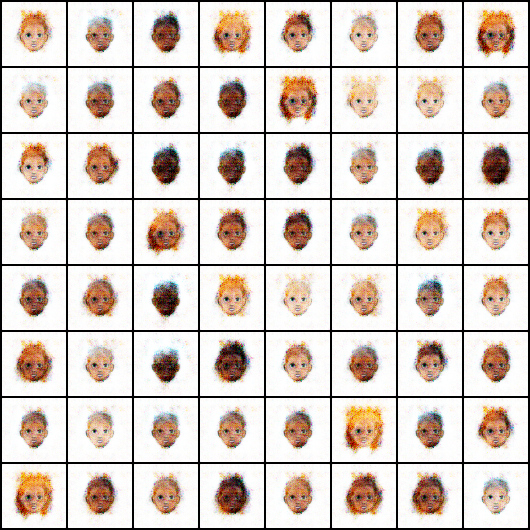

In [114]:
# Inspecting Images

Image('./generated/generated-images-0005.png')

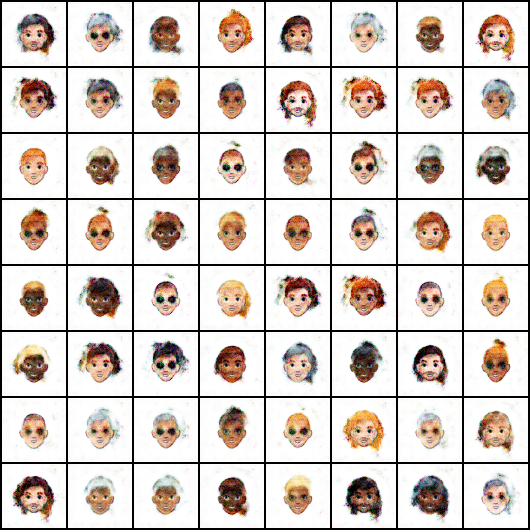

In [115]:
Image('./generated/generated-images-0010.png')

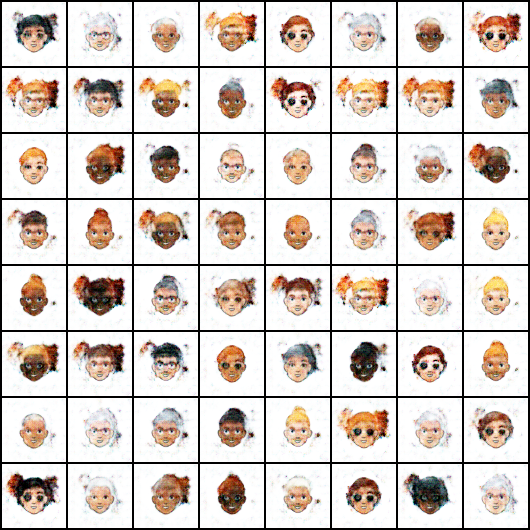

In [120]:
Image('./generated/generated-images-0015.png')

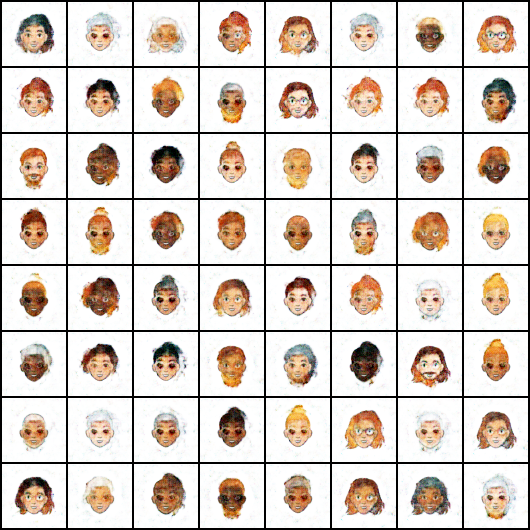

In [121]:
Image('./generated/generated-images-0020.png')

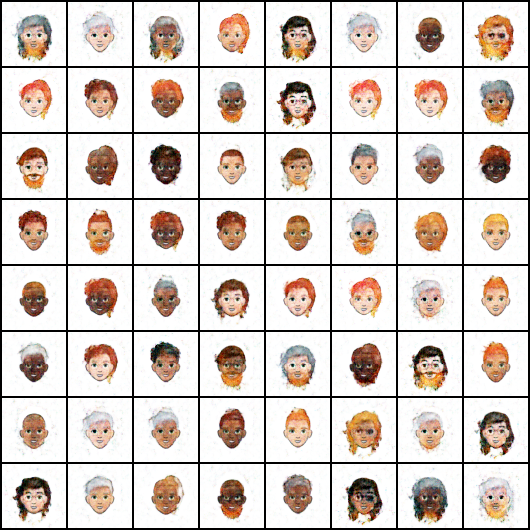

In [122]:
Image('./generated/generated-images-0025.png')

In [117]:
losses_g, losses_d, real_scores, fake_scores = history

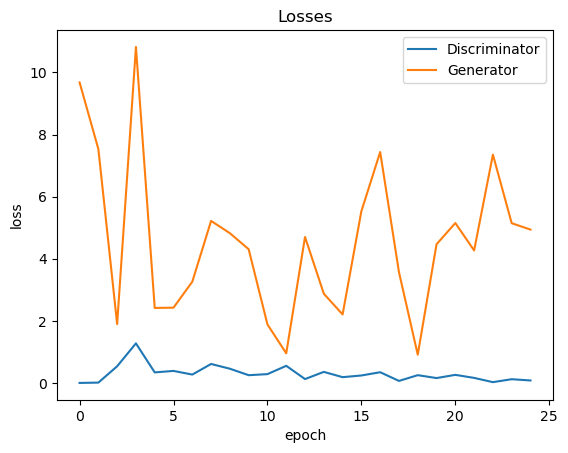

In [118]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

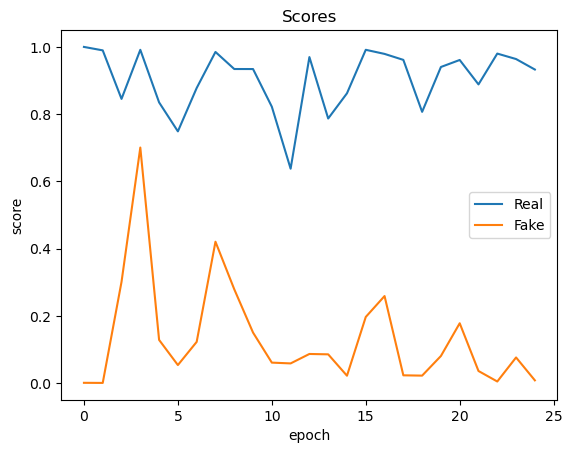

In [119]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');